# Импорты.

In [ ]:
!pip install -q pycm==3.4

In [ ]:
!pip install -q optuna

In [ ]:
!pip install -q lightgbm

In [ ]:
import pandas as pd
import os
from matplotlib import pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
import pycm
import xgboost as xgb
import seaborn as sns
import optuna
import pickle
from copy import deepcopy
import lightgbm as lgb
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

# Константы.

In [ ]:
classes = ['Typical Nevus', 'Atyical Nevus', 'Melanoma']

In [ ]:
y_train = pd.read_csv('/content/drive/MyDrive/my_bachelor_diploma/data/y_train.csv',
                      index_col=0)
y_val = pd.read_csv('/content/drive/MyDrive/my_bachelor_diploma/data/y_val.csv',
                      index_col=0)

In [ ]:
y_train.shape

(150, 1)

In [ ]:
X_train = pd.read_csv('/content/drive/MyDrive/my_bachelor_diploma/data/X_train.csv',
                      index_col=0).drop('name', axis = 1)
X_val = pd.read_csv('/content/drive/MyDrive/my_bachelor_diploma/data/X_val.csv',
                      index_col=0).drop('name', axis = 1)

In [ ]:
X = pd.concat([X_train, X_val])
y = pd.concat([y_train, y_val]).target.to_numpy()

In [ ]:
X.head()

Pigment Network  Streaks  Regression Areas  Blue Whitish Veil  White  \
164                0        1                 0                  0      0   
188                0        1                 1                  1      0   
78                 1        1                 1                  1      0   
29                 1        1                 1                  1      0   
109                0        1                 1                  1      0   

     Red  Light-Brown  Dark-Brown  Blue-Gray  Black  Asymmetry_0  Asymmetry_1  \
164    0            0           1          0      1          0.0          0.0   
188    0            1           1          0      1          0.0          0.0   
78     0            0           1          0      0          1.0          0.0   
29     0            1           1          0      0          1.0          0.0   
109    0            1           1          0      0          1.0          0.0   

     Asymmetry_2  Dots/Globus_A  Dots/Globus_T  Dots/Globus_AT  
164          1.0            1.0            0.0             0.0  
188          1.0            1.0            0.0             0.0  
78           0.0            1.0            0.0             0.0  
29           0.0            0.0            0.0             1.0  
109          0.0            0.0            1.0             0.0

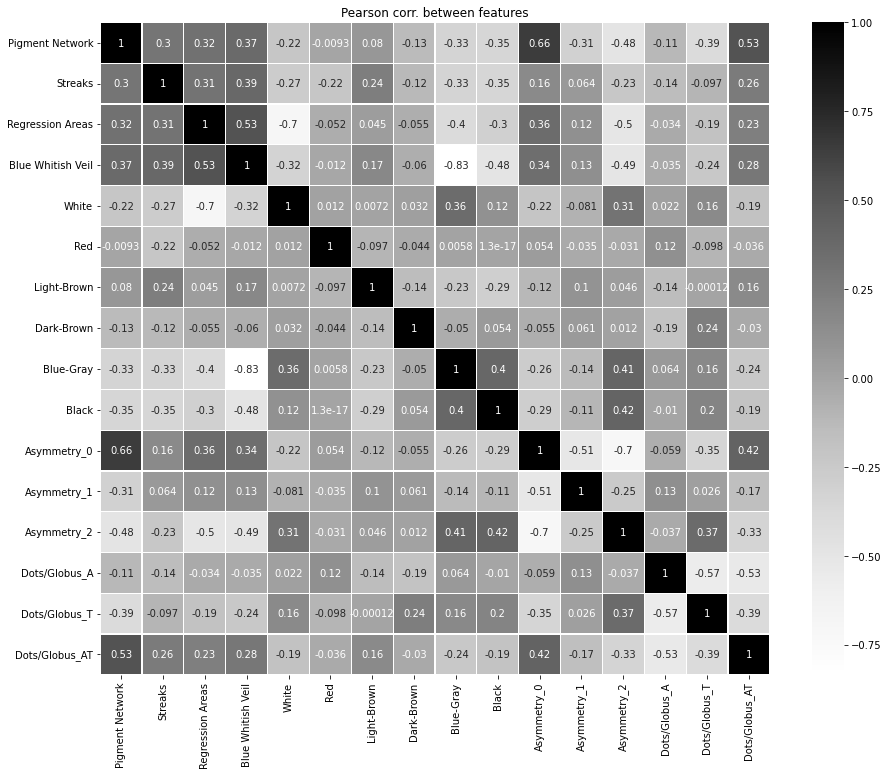

In [ ]:
sns.heatmap(X.corr(),annot=True,cmap='Greys',linewidths=0.2)
fig=plt.gcf()
fig.set_size_inches(15,12)
plt.title('Pearson corr. between features')
plt.show()

In [ ]:
import numpy as np
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random').fit_transform(X)
X_embedded.shape

(200, 2)

In [ ]:
y

array([2, 2, 0, 0, 1, 0, 0, 1, 2, 0, 2, 0, 1, 1, 1, 0, 2, 0, 1, 1, 0, 1,
       2, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 2, 0, 1, 1, 1, 0,
       2, 0, 0, 1, 1, 0, 0, 2, 0, 0, 0, 2, 0, 1, 1, 2, 0, 1, 1, 1, 1, 0,
       1, 1, 2, 2, 0, 1, 0, 1, 2, 1, 1, 1, 0, 2, 0, 1, 1, 0, 0, 2, 1, 1,
       0, 1, 1, 2, 0, 0, 0, 1, 1, 1, 0, 0, 0, 2, 0, 2, 2, 0, 1, 0, 0, 0,
       2, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 2, 0, 0, 0, 1, 0, 1, 0, 1, 1, 2,
       1, 1, 2, 0, 0, 1, 1, 0, 2, 1, 2, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1,
       2, 2, 2, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 2, 1, 1, 2, 2, 0, 0, 1, 2,
       2, 1, 2, 0, 1, 1, 1, 1, 0, 0, 1, 2, 1, 0, 0, 2, 0, 2, 1, 2, 1, 0,
       2, 0])

In [ ]:
y_color = list()
for i in range(len(y)):
  if y[i] == 2:
    y_color.append('Red')
  elif y[i] == 1:
     y_color.append('Blue')
  else:
     y_color.append('Green')

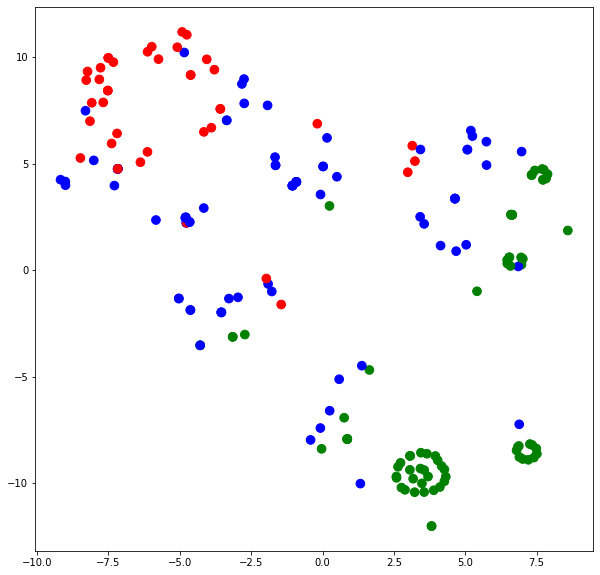

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
scatter = ax.scatter(X_embedded[:, 0], X_embedded[:, 1], c = y_color, s = 75)
#legend1 = ax.legend(*scatter.legend_elements(num=3),
#                   loc= "lower left", title="Classes", scatterpoints=3)
#ax.add_artist(legend1)
plt.show()

# Вспомогательные функции.

In [ ]:
def show_accuracy_on_table(model, X, y, mean=True):
  preds = model.predict_proba(X)
  predicted_classes = np.argmax(preds, axis=1)
  actual_classes = np.array(y)

  predictions_acc = {i : 0 for i in [0, 1, 2]}

  for i in range(len(actual_classes)):
    if actual_classes[i] == predicted_classes[i]:
      predictions_acc[actual_classes[i]] += 1

  for i in range(len(predictions_acc)):
    predictions_acc[i] /= len(actual_classes[actual_classes == i])

  if mean:
      return (predictions_acc[0] + predictions_acc[1] + predictions_acc[2])/3
      
  return ({classes[i] : predictions_acc[i] for i in range(3)})

In [ ]:
def my_cross_val_score(X, y, model, n_folds=5):
    X_folds = np.array_split(X, n_folds)
    y_folds = np.array_split(y, n_folds)

    results = list()

    for i in range(n_folds):
        X_train = np.vstack(X_folds[:i] + X_folds[i+1:])
        y_train = np.hstack(y_folds[:i] + y_folds[i+1:])

        X_val = X_folds[i]
        y_val = y_folds[i]

        xgb_classifier = deepcopy(model)
    
        xgb_classifier.fit(X_train, y_train, early_stopping_rounds=10,
                           eval_set=[(X_val, y_val)], verbose=False)
        
        results.append(show_accuracy_on_table(xgb_classifier, X_val, y_val))

    return results

# XGBoost.

In [ ]:
def objective(trial):
    
    eta = trial.suggest_uniform('eta', 0.1, 0.5)
    gamma = trial.suggest_uniform('gamma', 0.1, 0.5)
    max_depth = trial.suggest_int('max_depth', 1, 6)
    reg_lambda = trial.suggest_uniform('reg_lambda', 0, 2)
    reg_alpha = trial.suggest_uniform('reg_alpha', 0, 2)

    model = xgb.XGBClassifier(learning_rate=eta,
                        n_estimators = 10000, max_depth=max_depth,
                        reg_lambda=reg_lambda, reg_alpha=reg_alpha,
                        gamma = gamma, use_label_encoder=False, verbosity=0)

    scores = my_cross_val_score(X.to_numpy(), y, model)
    
    return np.mean(scores)

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=200)

[I 2022-04-13 10:02:44,960] A new study created in memory with name: no-name-767a8ea8-a089-4730-a23a-89dcab0b9c2e
[I 2022-04-13 10:02:45,151] Trial 0 finished with value: 0.8658970658970659 and parameters: {'eta': 0.3531077131775846, 'gamma': 0.3273634710170581, 'max_depth': 5, 'reg_lambda': 0.2538068547803858, 'reg_alpha': 1.9017286889179372}. Best is trial 0 with value: 0.8658970658970659.
[I 2022-04-13 10:02:45,329] Trial 1 finished with value: 0.8694684944684944 and parameters: {'eta': 0.14850317910772534, 'gamma': 0.40270290037839396, 'max_depth': 6, 'reg_lambda': 1.2348960478261966, 'reg_alpha': 1.8156816366864605}. Best is trial 1 with value: 0.8694684944684944.
[I 2022-04-13 10:02:45,505] Trial 2 finished with value: 0.8611351611351612 and parameters: {'eta': 0.3610343100179917, 'gamma': 0.36323738227786573, 'max_depth': 3, 'reg_lambda': 0.09374545893816988, 'reg_alpha': 1.4184151381158008}. Best is trial 1 with value: 0.8694684944684944.
[I 2022-04-13 10:02:45,682] Trial 3 fin

In [ ]:
study.best_params

{'eta': 0.4810735023253023,
 'gamma': 0.3999576153986822,
 'max_depth': 4,
 'reg_alpha': 0.003067047732019575,
 'reg_lambda': 0.00843909082762151}

In [ ]:
xgb_classifier = xgb.XGBClassifier(learning_rate=0.4810735023253023,
                        n_estimators = 10000, max_depth=4,
                        reg_lambda=0.00843909082762151, reg_alpha=0.003067047732019575,
                        gamma = 0.3999576153986822, use_label_encoder=False)

In [ ]:
xgb_classifier.fit(X_train, y_train.target.to_numpy(), early_stopping_rounds=10,
                  eval_set=[(X_val, y_val.target.to_numpy())], eval_metric='mlogloss')

[0]	validation_0-mlogloss:0.615454
Will train until validation_0-mlogloss hasn't improved in 10 rounds.
[1]	validation_0-mlogloss:0.431834
[2]	validation_0-mlogloss:0.329181
[3]	validation_0-mlogloss:0.26969
[4]	validation_0-mlogloss:0.237629
[5]	validation_0-mlogloss:0.211036
[6]	validation_0-mlogloss:0.190849
[7]	validation_0-mlogloss:0.182995
[8]	validation_0-mlogloss:0.180465
[9]	validation_0-mlogloss:0.181115
[10]	validation_0-mlogloss:0.177199
[11]	validation_0-mlogloss:0.183206
[12]	validation_0-mlogloss:0.183687
[13]	validation_0-mlogloss:0.183951
[14]	validation_0-mlogloss:0.184094
[15]	validation_0-mlogloss:0.184171
[16]	validation_0-mlogloss:0.184211
[17]	validation_0-mlogloss:0.184231
[18]	validation_0-mlogloss:0.184241
[19]	validation_0-mlogloss:0.184246
[20]	validation_0-mlogloss:0.184248
Stopping. Best iteration:
[10]	validation_0-mlogloss:0.177199



XGBClassifier(gamma=0.3999576153986822, learning_rate=0.4810735023253023,
              max_depth=4, n_estimators=10000, objective='multi:softprob',
              reg_alpha=0.003067047732019575, reg_lambda=0.00843909082762151,
              use_label_encoder=False)

In [ ]:
file_name = "/content/drive/MyDrive/my_bachelor_diploma/trained_models/boosters/xgb_classifier.pkl"

# save
pickle.dump(xgb_classifier, open(file_name, "wb"))

In [ ]:
xgb_classifier = pickle.load(open("/content/drive/MyDrive/my_bachelor_diploma/trained_models/boosters/xgb_classifier.pkl",
                         "rb"))

In [ ]:
#Plot the data:
my_colors = ['gold', 'olivedrab', 'darkorange', 'maroon', 'indigo', 'brown', 'blue',
          'gray', 'tomato', 'olive', 'lime', 'steelblue', 'hotpink', 'cyan', 
          'slategray', 'orangered', 'darkviolet']

In [ ]:
xgb_classifier.feature_importances_

array([0.39046088, 0.02174032, 0.03496077, 0.21619892, 0.05114945,
       0.        , 0.03038296, 0.02388285, 0.        , 0.03090904,
       0.03158917, 0.00867857, 0.10426562, 0.02110246, 0.01802426,
       0.01665468], dtype=float32)

In [ ]:
s = pd.Series(
    xgb_classifier.feature_importances_,
    index = list(X.columns)
)

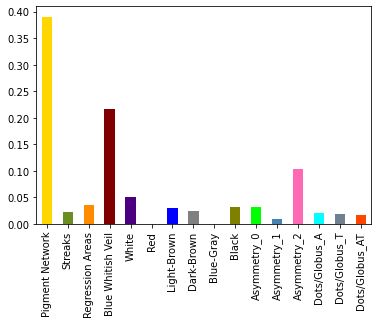

In [ ]:
s.plot(kind='bar', color=my_colors)

In [ ]:
show_accuracy_on_table(xgb_classifier, X_val,
                    y_val.target.to_numpy(), mean=False)

{'Atyical Nevus': 1.0, 'Melanoma': 0.7857142857142857, 'Typical Nevus': 1.0}

In [84]:
predicted_classes = np.array(xgb_classifier.predict(X_val))
actual_classes = np.array(y_val.target)

In [85]:
predicted_probs = np.array(xgb_classifier.predict_proba(X_val))

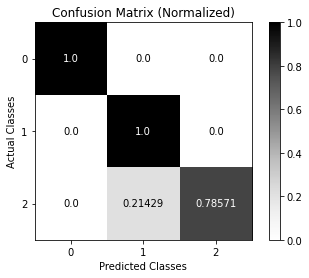

In [ ]:
cm = pycm.ConfusionMatrix(actual_classes, predicted_classes, digit=5)
cm.plot(cmap=plt.cm.Greys, number_label=True, normalized=True)

In [ ]:
print(f1_score(actual_classes, predicted_classes, average='macro'))

0.9343589743589743


In [ ]:
print(classification_report(actual_classes, predicted_classes, target_names = ['Nevus', 'Atypical Nevus', 'Melanoma']))

                precision    recall  f1-score   support

         Nevus       1.00      1.00      1.00        18
Atypical Nevus       0.86      1.00      0.92        18
      Melanoma       1.00      0.79      0.88        14

      accuracy                           0.94        50
     macro avg       0.95      0.93      0.93        50
  weighted avg       0.95      0.94      0.94        50



In [ ]:
actual_classes[actual_classes <= 1] = 1

In [ ]:
predicted_classes[predicted_classes <= 1] = 1

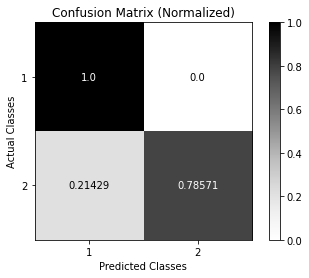

In [ ]:
cm = pycm.ConfusionMatrix(actual_classes, predicted_classes, digit=5)
cm.plot(cmap=plt.cm.Greys, number_label=True, normalized=True)

In [ ]:
print(f1_score(actual_classes, predicted_classes, average='macro'))

0.92


In [ ]:
print(classification_report(actual_classes, predicted_classes, target_names = ['Nevus/Atypical Nevus', 'Melanoma']))

                      precision    recall  f1-score   support

Nevus/Atypical Nevus       0.92      1.00      0.96        36
            Melanoma       1.00      0.79      0.88        14

            accuracy                           0.94        50
           macro avg       0.96      0.89      0.92        50
        weighted avg       0.94      0.94      0.94        50



# LightGBM

In [ ]:
def objective(trial):
    lr = trial.suggest_uniform('lr', 0.05, 0.5)
    num_leaves = trial.suggest_int('num_leaves', 20, 40)
    subsample = trial.suggest_float('subsample', 0.4, 1.0),
    colsample_bytree =  trial.suggest_float('colsample_bytree', 0.4, 1.0),
    reg_lambda = trial.suggest_uniform('reg_lambda', 0, 2)
    reg_alpha = trial.suggest_uniform('reg_alpha', 0, 2)
    min_child_samples = trial.suggest_int('min_child_samples', 1, 10)

    model = lgb.LGBMClassifier(learning_rate=lr, num_leaves = num_leaves,
                               objective = 'multiclass', subsample = subsample,
                               colsample_bytree = colsample_bytree,
                               reg_lambda = reg_lambda, reg_alpha = reg_alpha,
                               min_child_samples = min_child_samples)

    scores = my_cross_val_score(X.to_numpy(), y, model)
    
    return np.mean(scores)

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=200)

[I 2022-04-13 09:43:03,880] A new study created in memory with name: no-name-f879fd7d-8ba7-4ebc-a6d8-41da86de8493
[I 2022-04-13 09:43:03,975] Trial 0 finished with value: 0.8962121212121211 and parameters: {'lr': 0.30960141657712975, 'num_leaves': 23, 'subsample': 0.6321450644557826, 'colsample_bytree': 0.6811772384938646, 'reg_lambda': 0.21304705474912233, 'reg_alpha': 0.40078556457764636, 'min_child_samples': 5}. Best is trial 0 with value: 0.8962121212121211.
[I 2022-04-13 09:43:04,059] Trial 1 finished with value: 0.8674290524290523 and parameters: {'lr': 0.4316639572390314, 'num_leaves': 32, 'subsample': 0.6319437091221222, 'colsample_bytree': 0.9306614786742605, 'reg_lambda': 0.522299808566032, 'reg_alpha': 0.37516998681672287, 'min_child_samples': 10}. Best is trial 0 with value: 0.8962121212121211.
[I 2022-04-13 09:43:04,182] Trial 2 finished with value: 0.8533549783549784 and parameters: {'lr': 0.22389827473171503, 'num_leaves': 29, 'subsample': 0.95620670102663, 'colsample_by

In [ ]:
study.best_params

{'colsample_bytree': 0.8227773219478106,
 'lr': 0.35935819269501984,
 'min_child_samples': 2,
 'num_leaves': 27,
 'reg_alpha': 0.0507479529990042,
 'reg_lambda': 0.03823814225605901,
 'subsample': 0.4009936932280039}

In [87]:
lgb_classifier = lgb.LGBMClassifier(learning_rate=0.35935819269501984, num_leaves = 27,
                               subsample = 0.4009936932280039, min_child_samples = 2,
                               colsample_bytree = 0.8227773219478106,
                               reg_lambda = 0.03823814225605901, reg_alpha = 0.0507479529990042)

In [ ]:
lgb_classifier.fit(X_train, y_train, early_stopping_rounds=10,
                           eval_set=[(X_val, y_val)])

[1]	valid_0's multi_logloss: 0.745543
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's multi_logloss: 0.539862
[3]	valid_0's multi_logloss: 0.442747
[4]	valid_0's multi_logloss: 0.377545
[5]	valid_0's multi_logloss: 0.312097
[6]	valid_0's multi_logloss: 0.270581
[7]	valid_0's multi_logloss: 0.246034
[8]	valid_0's multi_logloss: 0.228245
[9]	valid_0's multi_logloss: 0.219807
[10]	valid_0's multi_logloss: 0.211429
[11]	valid_0's multi_logloss: 0.203278
[12]	valid_0's multi_logloss: 0.196458
[13]	valid_0's multi_logloss: 0.193196
[14]	valid_0's multi_logloss: 0.191716
[15]	valid_0's multi_logloss: 0.189528
[16]	valid_0's multi_logloss: 0.193088
[17]	valid_0's multi_logloss: 0.192862
[18]	valid_0's multi_logloss: 0.190041
[19]	valid_0's multi_logloss: 0.188674
[20]	valid_0's multi_logloss: 0.192224
[21]	valid_0's multi_logloss: 0.190216
[22]	valid_0's multi_logloss: 0.192136
[23]	valid_0's multi_logloss: 0.202586
[24]	valid_0's multi_logloss: 0.202867
[25]	valid_

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LGBMClassifier(colsample_bytree=0.8227773219478106,
               learning_rate=0.35935819269501984, min_child_samples=2,
               num_leaves=27, reg_alpha=0.0507479529990042,
               reg_lambda=0.03823814225605901, subsample=0.4009936932280039)

In [ ]:
file_name = "/content/drive/MyDrive/my_bachelor_diploma/trained_models/boosters/lgb_classifier.pkl"

# save
pickle.dump(lgb_classifier, open(file_name, "wb"))

In [88]:
lgb_classifier = pickle.load(open("/content/drive/MyDrive/my_bachelor_diploma/trained_models/boosters/lgb_classifier.pkl",
                         "rb"))

In [79]:
lgb_classifier.feature_importances_

array([40, 26, 32, 36, 25,  1, 79, 30, 14, 51, 33,  5, 15,  7, 60, 35])

In [82]:
s = pd.Series(
    lgb_classifier.feature_importances_,
    index = list(X.columns)
)

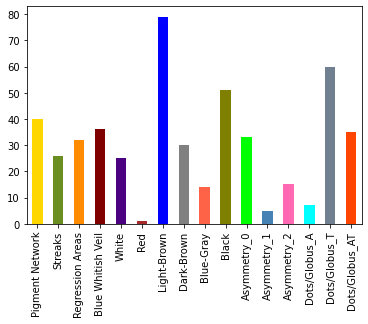

In [83]:
s.plot(kind='bar', color=my_colors)

In [ ]:
show_accuracy_on_table(lgb_classifier, X_val,
                    y_val.target.to_numpy(), mean=False)

{'Atyical Nevus': 1.0, 'Melanoma': 0.7857142857142857, 'Typical Nevus': 1.0}

In [89]:
predicted_classes = np.array(lgb_classifier.predict(X_val))
actual_classes = np.array(y_val.target)

In [92]:
predicted_probs_2 = np.array(lgb_classifier.predict_proba(X_val))

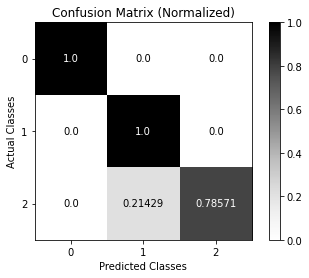

In [ ]:
cm = pycm.ConfusionMatrix(actual_classes, predicted_classes, digit=5)
cm.plot(cmap=plt.cm.Greys, number_label=True, normalized=True)

In [ ]:
print(f1_score(actual_classes, predicted_classes, average='macro'))

0.9343589743589743


In [ ]:
print(classification_report(actual_classes, predicted_classes, target_names = ['Nevus', 'Atypical Nevus', 'Melanoma']))

                precision    recall  f1-score   support

         Nevus       1.00      1.00      1.00        18
Atypical Nevus       0.86      1.00      0.92        18
      Melanoma       1.00      0.79      0.88        14

      accuracy                           0.94        50
     macro avg       0.95      0.93      0.93        50
  weighted avg       0.95      0.94      0.94        50



In [ ]:
actual_classes[actual_classes <= 1] = 1

In [ ]:
predicted_classes[predicted_classes <= 1] = 1

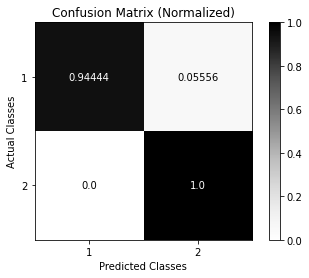

In [ ]:
cm = pycm.ConfusionMatrix(actual_classes, predicted_classes, digit=5)
cm.plot(cmap=plt.cm.Greys, number_label=True, normalized=True)

In [ ]:
print(f1_score(actual_classes, predicted_classes, average='macro'))

0.9523809523809523


In [ ]:
print(classification_report(actual_classes, predicted_classes, target_names = ['Nevus/Atypical Nevus', 'Melanoma']))

                      precision    recall  f1-score   support

Nevus/Atypical Nevus       1.00      0.94      0.97        36
            Melanoma       0.88      1.00      0.93        14

            accuracy                           0.96        50
           macro avg       0.94      0.97      0.95        50
        weighted avg       0.96      0.96      0.96        50

